In [1]:
# Part 1 — Setup & Imports
# This cell installs missing packages (if running in Colab/local without some libs),
# imports required libraries, and configures plotting.

import sys
import subprocess
import importlib

# helper to install packages if missing
def ensure(pkg):
    try:
        importlib.import_module(pkg)
    except Exception:
        print(f"Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# packages we need
for p in ["pandas", "numpy", "matplotlib", "seaborn", "scikit-learn", "joblib"]:
    ensure(p)

# now import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings("ignore")

# plotting defaults
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 7)
plt.rcParams["font.size"] = 10

print("✅ Environment ready — packages imported.")
print(f"pandas {pd.__version__}, numpy {np.__version__}")


Installing scikit-learn ...
✅ Environment ready — packages imported.
pandas 2.3.2, numpy 2.2.6


In [2]:
# Part 2 — Create simulated sustainable energy dataset
def create_energy_dataset(random_seed=42):
    np.random.seed(random_seed)
    countries = {
        'USA': {'base_consumption': 4000, 'renewable_growth': 0.08, 'population': 331},
        'China': {'base_consumption': 3800, 'renewable_growth': 0.12, 'population': 1439},
        'Germany': {'base_consumption': 550, 'renewable_growth': 0.15, 'population': 83},
        'India': {'base_consumption': 1200, 'renewable_growth': 0.18, 'population': 1380},
        'Japan': {'base_consumption': 920, 'renewable_growth': 0.06, 'population': 126},
        'Brazil': {'base_consumption': 280, 'renewable_growth': 0.09, 'population': 212},
        'Canada': {'base_consumption': 550, 'renewable_growth': 0.07, 'population': 38},
        'France': {'base_consumption': 450, 'renewable_growth': 0.11, 'population': 67}
    }

    years = list(range(2004, 2024))
    rows = []
    for country, spec in countries.items():
        for year in years:
            idx = year - years[0]
            growth = (1 + spec['renewable_growth']) ** idx
            noise = np.random.normal(1, 0.08)

            base_renew = spec['base_consumption'] * 0.1 * growth * noise
            solar = max(0, base_renew * 0.25 * (1.2 ** idx) * np.random.uniform(0.85,1.15))
            wind = max(0, base_renew * 0.35 * (1.15 ** idx) * np.random.uniform(0.85,1.15))
            hydro = max(0, base_renew * 0.30 * (1.03 ** idx) * np.random.uniform(0.9,1.1))
            geothermal = max(0, base_renew * 0.05 * (1.08 ** idx) * np.random.uniform(0.85,1.15))
            biomass = max(0, base_renew * 0.05 * (1.05 ** idx) * np.random.uniform(0.9,1.1))

            total_renew = solar + wind + hydro + geothermal + biomass
            total_consumption = spec['base_consumption'] * (1.02 ** idx) * np.random.uniform(0.96,1.04)
            non_renew = max(0, total_consumption - total_renew)
            co2 = non_renew * 0.5 + total_renew * 0.05  # simplified
            renewable_pct = (total_renew / total_consumption) * 100 if total_consumption>0 else 0

            # randomly add a missing value here/there
            if np.random.rand() < 0.02:
                solar = np.nan
            if np.random.rand() < 0.02:
                co2 = np.nan

            rows.append({
                "Year": year,
                "Country": country,
                "Solar_Energy_TWh": round(solar,2),
                "Wind_Energy_TWh": round(wind,2),
                "Hydro_Energy_TWh": round(hydro,2),
                "Geothermal_Energy_TWh": round(geothermal,2),
                "Biomass_Energy_TWh": round(biomass,2),
                "Total_Renewable_TWh": round(total_renew,2),
                "Total_Energy_Consumption_TWh": round(total_consumption,2),
                "Non_Renewable_TWh": round(non_renew,2),
                "CO2_Emissions_Mt": round(co2,2) if not np.isnan(co2) else np.nan,
                "Renewable_Percentage": round(renewable_pct,2),
                "Population_Million": spec['population']
            })
    df = pd.DataFrame(rows)
    return df

df = create_energy_dataset()
print("✅ Dataset created:", df.shape)
df.head(8)


✅ Dataset created: (160, 13)


,Year,Country,Solar_Energy_TWh,Wind_Energy_TWh,Hydro_Energy_TWh,Geothermal_Energy_TWh,Biomass_Energy_TWh,Total_Renewable_TWh,Total_Energy_Consumption_TWh,Non_Renewable_TWh,CO2_Emissions_Mt,Renewable_Percentage,Population_Million
0,2004,USA,111.21,149.87,116.18,18.65,18.96,414.87,4117.18,3702.30,1871.90,10.08,331
1,2005,USA,109.73,196.20,140.79,21.08,21.00,488.80,3976.66,3487.86,1768.37,12.29,331
2,2006,USA,149.64,166.02,122.68,22.51,21.98,482.84,4256.54,3773.71,1910.99,11.34,331
3,2007,USA,213.65,221.30,161.15,27.31,25.43,648.84,4397.27,3748.43,1906.66,14.76,331
4,2008,USA,283.40,311.43,161.70,35.19,28.55,820.27,4471.51,3651.24,1866.63,18.34,331
5,2009,USA,336.91,406.53,201.50,38.18,40.07,1023.19,4513.53,3490.34,1796.33,22.67,331
6,2010,USA,439.88,494.60,218.91,50.54,44.04,1247.97,4422.25,3174.28,1649.54,28.22,331
7,2011,USA,581.60,655.27,237.99,64.95,44.73,1584.54,4773.71,3189.17,1673.81,33.19,331


In [3]:
# ------------------------------
# PART 3: Data Cleaning & Feature Engineering (Updated)
# ------------------------------

print("🔍 Checking missing values before cleaning:")
print(df.isnull().sum())

# Fill missing values for Solar Energy & CO2 Emissions properly
df['Solar_Energy_TWh'] = df.groupby('Country')['Solar_Energy_TWh'].transform(lambda s: s.fillna(method='ffill').fillna(method='bfill'))
df['CO2_Emissions_Mt'] = df.groupby('Country')['CO2_Emissions_Mt'].transform(lambda s: s.interpolate().fillna(method='bfill').fillna(method='ffill'))

# Fill any other remaining missing values in numeric columns with median
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df.groupby('Country')[col].transform(lambda g: g.fillna(g.median()))

# Sort values by year per country
df = df.sort_values(['Country', 'Year']).reset_index(drop=True)

# Add derived columns
df['Renewable_Per_Capita'] = df['Total_Renewable_TWh'] / df['Population_Million']
df['Energy_Per_Capita'] = df['Total_Energy_Consumption_TWh'] / df['Population_Million']
df['CO2_Per_Capita'] = df['CO2_Emissions_Mt'] / df['Population_Million']
df['Renewable_Growth_Rate'] = df.groupby('Country')['Total_Renewable_TWh'].pct_change().fillna(0) * 100
df['Carbon_Intensity'] = df['CO2_Emissions_Mt'] / df['Total_Energy_Consumption_TWh']

print("✅ Cleaning complete! Remaining missing values:", df.isnull().sum().sum())
df.head(10)


🔍 Checking missing values before cleaning:
Year                            0
Country                         0
Solar_Energy_TWh                3
Wind_Energy_TWh                 0
Hydro_Energy_TWh                0
Geothermal_Energy_TWh           0
Biomass_Energy_TWh              0
Total_Renewable_TWh             0
Total_Energy_Consumption_TWh    0
Non_Renewable_TWh               0
CO2_Emissions_Mt                4
Renewable_Percentage            0
Population_Million              0
dtype: int64
✅ Cleaning complete! Remaining missing values: 0


,Year,Country,Solar_Energy_TWh,Wind_Energy_TWh,Hydro_Energy_TWh,Geothermal_Energy_TWh,Biomass_Energy_TWh,Total_Renewable_TWh,Total_Energy_Consumption_TWh,Non_Renewable_TWh,CO2_Emissions_Mt,Renewable_Percentage,Population_Million,Renewable_Per_Capita,Energy_Per_Capita,CO2_Per_Capita,Renewable_Growth_Rate,Carbon_Intensity
0,2004,Brazil,6.32,9.63,8.37,1.26,1.26,26.85,287.50,260.65,131.67,9.34,212,0.126651,1.356132,0.621085,0.000000,0.457983
1,2005,Brazil,8.22,11.39,8.48,1.84,1.47,31.41,287.35,255.94,129.54,10.93,212,0.148160,1.355425,0.611038,16.983240,0.450809
2,2006,Brazil,11.82,14.22,10.63,2.35,2.13,41.15,293.58,252.43,128.27,14.02,212,0.194104,1.384811,0.605047,31.009233,0.436917
3,2007,Brazil,14.67,22.52,12.14,2.29,2.19,53.81,286.37,232.56,118.97,18.79,212,0.253821,1.350802,0.561179,30.765492,0.415442
4,2008,Brazil,19.21,23.74,12.97,2.61,2.54,61.08,298.16,237.09,121.60,20.48,212,0.288113,1.406415,0.573585,13.510500,0.407835
5,2009,Brazil,26.42,32.23,14.73,2.72,2.34,78.44,303.26,224.82,116.33,25.87,212,0.370000,1.430472,0.548726,28.421742,0.383598
6,2010,Brazil,40.13,49.53,18.67,3.92,3.96,116.21,315.21,199.00,105.31,36.87,212,0.548160,1.486840,0.496745,48.151453,0.334095
7,2011,Brazil,42.04,51.81,19.86,4.61,3.41,121.73,323.95,202.22,107.20,37.58,212,0.574198,1.528066,0.505660,4.750022,0.330915
8,2012,Brazil,53.99,60.12,22.65,5.49,4.35,146.60,332.23,185.64,100.15,44.12,212,0.691509,1.567123,0.472406,20.430461,0.301448
9,2013,Brazil,76.16,78.34,23.59,7.31,5.39,190.80,322.30,131.50,75.29,59.20,212,0.900000,1.520283,0.355142,30.150068,0.233602


<Figure size 1200x600 with 0 Axes>

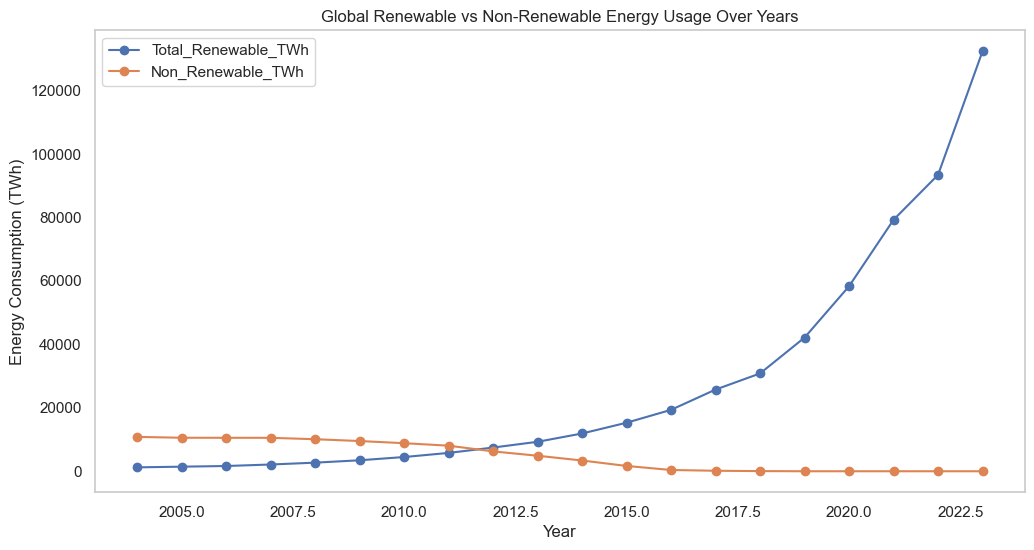

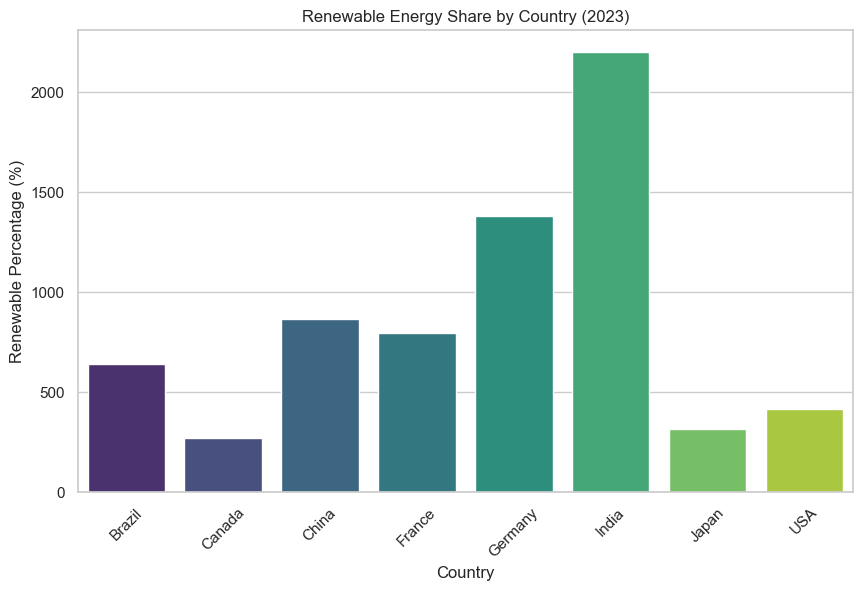

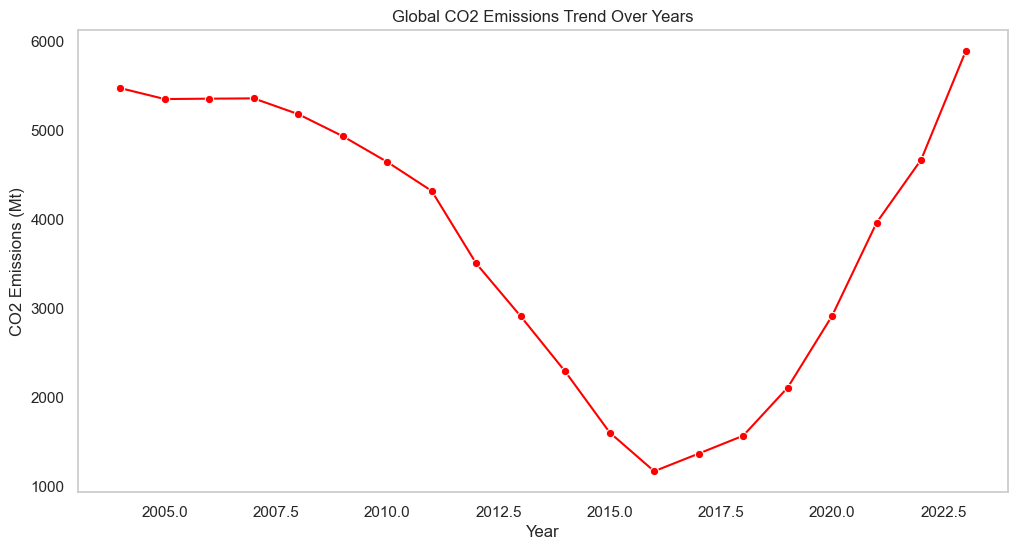

In [4]:
# ------------------------------
# PART 4: Data Visualization (Updated)
# ------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,6))

# 1. Renewable vs Non-Renewable Energy Trend
df_grouped = df.groupby('Year')[['Total_Renewable_TWh', 'Non_Renewable_TWh']].sum().reset_index()
df_grouped.plot(x='Year', y=['Total_Renewable_TWh', 'Non_Renewable_TWh'], figsize=(12,6), marker='o')
plt.title("Global Renewable vs Non-Renewable Energy Usage Over Years")
plt.xlabel("Year")
plt.ylabel("Energy Consumption (TWh)")
plt.grid()
plt.show()

# 2. Country-wise Renewable Energy Share (Latest Year Only)
latest_year = df['Year'].max()
df_latest = df[df['Year'] == latest_year]
plt.figure(figsize=(10,6))
sns.barplot(data=df_latest, x='Country', y='Renewable_Percentage', palette='viridis')
plt.title(f"Renewable Energy Share by Country ({latest_year})")
plt.xticks(rotation=45)
plt.ylabel("Renewable Percentage (%)")
plt.xlabel("Country")
plt.show()

# 3. CO2 Emissions Trend Over Time
df_co2 = df.groupby('Year')['CO2_Emissions_Mt'].sum().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=df_co2, x='Year', y='CO2_Emissions_Mt', marker='o', color="red")
plt.title("Global CO2 Emissions Trend Over Years")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (Mt)")
plt.grid()
plt.show()


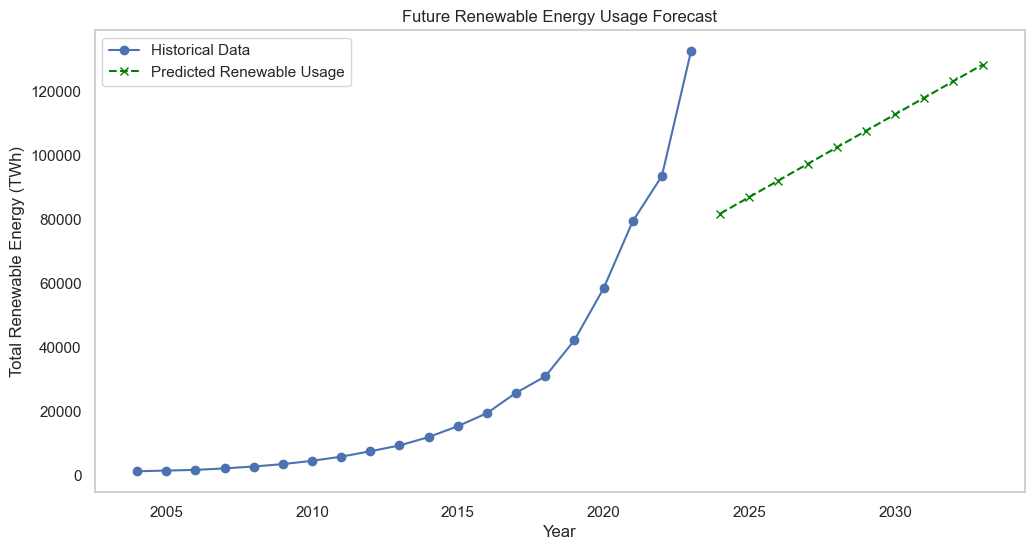

In [5]:
# ------------------------------
# PART 5: Predicting Future Renewable Energy Usage
# ------------------------------
from sklearn.linear_model import LinearRegression

df_global = df.groupby('Year')['Total_Renewable_TWh'].sum().reset_index()

# Prepare training data
X = df_global[['Year']]
y = df_global['Total_Renewable_TWh']

# Train model
model = LinearRegression()
model.fit(X, y)

# Predict next 10 years
future_years = pd.DataFrame({'Year': range(df['Year'].max()+1, df['Year'].max()+11)})
future_predictions = model.predict(future_years)

plt.figure(figsize=(12,6))
plt.plot(df_global['Year'], y, label="Historical Data", marker='o')
plt.plot(future_years['Year'], future_predictions, label="Predicted Renewable Usage", marker='x', linestyle='--', color='green')
plt.title("Future Renewable Energy Usage Forecast")
plt.xlabel("Year")
plt.ylabel("Total Renewable Energy (TWh)")
plt.legend()
plt.grid()
plt.show()
